In [1]:
from numpy import *
from scipy.stats import loguniform
from scipy.integrate import solve_ivp
from scipy.special import loggamma
from scipy.optimize import minimize
from sys import argv
from numba import njit
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size':12})
colors = cm.plasma(linspace(0,1,12))
import random
random.seed(10)

nStages = 3
nMutations = 2
locationIndex = 4
datafolder = '/Users/amallela/Documents/bmab/parsimony-checks/'
nms = ['NYC','LA','Chicago','Dallas','Houston','DC','Philadelphia','Miami','Atlanta','Boston','Phoenix','SanFrancisco','Riverside','Detroit','Seattle']
population = [19216182,13214799,9458539,7573136,7066141,6280487,6166488,6102434,6020364,4948203,4873019,4731803,4650631,4319629,3979845]
prefix = nms[locationIndex]
totalPopulation = population[locationIndex]
filePrefix = prefix+'-n'+str(nStages)
NYTNewCases = array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,3,0,4,0,2,0,2,5,3,2,2,4,19,14,34,24,18,27,61,78,77,85,242,139,63,202,235,112,270,335,153,514,376,369,772,327,394,97,189,266,292,281,263,277,219,217,224,212,190,238,209,151,149,228,269,300,299,238,198,166,257,203,225,288,254,103,339,296,298,237,310,142,382,214,293,314,270,276,281,170,10,453,337,292,334,269,80,468,466,337,480,466,552,207,402,505,492,427,540,490,277,668,980,857,605,1601,1424,450,2314,1661,1831,1659,1901,1313,343,1748,1189,2028,1867,1657,734,770,2287,2170,1295,1605,1811,2448,1598,2762,2659,2625,2288,2640,1974,1109,2070,1930,2083,2045,1564,1916,1390,1582,2157,1986,2223,2677,2304,1894,1926,2255,2367,1625,1831,2022,1317,1659,1667,1379,1634,2094,2181,694,1471,1703,1827,1473,1487,1511,930,1701,1470,1401,694,1758,1959,1248,1130,1089,972,1035,1301,1020,960,88,1006,1249,1035,1844,708,1233,1700,3202,842,1210,1076,970,640,14300,703,880,818,978,543,491,686,872,610,1085,3098,1153,562,747,908,979,641,624,647,586,668,637,1017,619,793,515,419,745,700,1222,1000,929,1169,452,904,700,1107,766,882,895,516,875,702,794,1130,939,727,873,831,1360,1908,1971,1423,1065,1144,1300,990,2028,2064,1660,1811,947,2159,3091,2552,749,320,733,3001,2454,1279,2305,2871,3241,2486,2471,2461,1764,2798,2137,5426,1705,2036,2420,2673,3891,2880,3006,1913,2804,3524,3662,3565,1563,524,196,7434,2653,4871,3225,1909,2561,3448,3439,3953,4562,4288,4147,3747,4361,3375,5990,4002,2910,8044,6536,3788,4148,2121,4540,4620,4399,2501,3042,1760,4882,6936,3555,3720,4380,3731,3386,3421,3430,3876,3082,2662,1320,1714,1823,1746,1932,2988,2572,2819,1704,1416,165,1115,128,2885,1029,1509,1749,1477,1323,1656,4186,1005,1762,1724,3274,2628,2056,1844,1357,1225,1043,1397,1577,2305,1414,1318,955,753,2124,1263,873,1487,852,864,657,1507,941,972,1309,1475,883,1396,1414,980,913,682,764,679,706,1210,904,973,885,704,668,1165,1146,1164,907,856,514,695,579,1045,1285,1036,629,1137,583,790,806,880,887,858,615,375,885,699,635,621,736,422,487,538,454,660,304,496,383,193,342,768,638,466,296,298,302,585,793,488,611,378,269,71,102,143,606,811,296,346,379,95,637,598,474,222,21,204,233,321,219,-236,-55,273,19,13,401,82,39,127,227,19,-86,-62,397,285,165,452,86,67,40,1211,868,553,509,159,150,987,458,677,786,986,289,318,1087,1426,2393,1199,1666,285,555,2418,1467,5936,5536,1363,1741,1253,4068,1663,5480,5336,5468,1138,890,3640,6655,2717,4637,2655,2438,1150,7018,2699,5920,9273,9983,1014,1036,4534,5808,3103,3343,3132,1570,6106,4274,6616,3553,4649,7085,1086,927,775,8226,10712,2386,3740,1442,1559,4890,6889,3479,3644,2607,1000,945,4388,1887,2666,4511,1566,1703,1026,3119,3627,2162,989,2830,507,613,2369,2827,1774,1148,1548,571,460,1771,2501,1256,1330,605,533,372,1183,648,1609,630,742,379,166,1235,664,1666,734,566,43])
vr_daily=load('vac.npy')
x1 = linspace(1, len(vr_daily[locationIndex])+2, len(vr_daily[locationIndex])+2) 
y1 = vr_daily[locationIndex]
y1 = append(y1, [0,0])

@njit
def fv(x1,y1,t):
    xm=mean(x1)
    ym=mean(y1)
    sumnr=0
    sumdr=0
    length=len(x1)
    for i in range(0,length):
        sumnr=sumnr+((x1[i]-xm)*(y1[i]-ym))
        sumdr=sumdr+((x1[i]-xm)*(x1[i]-xm))
    m=sumnr/sumdr
    c=ym-(m*xm)
    return((m*t)+c)
    
tSpan = linspace(0, len(NYTNewCases)-1, len(NYTNewCases))    
tSpanSimulation = linspace(0, len(NYTNewCases), len(NYTNewCases)+1)    

S0 = totalPopulation
mb = 0.1
relEI = 1.1
relA = 0.9
kL = 0.94
gI = 0.12
fA = 0.44
fH = 0.054
kH = fH*gI
kR = (1-fH)*gI
kQ = 0.0038
jQ = 0.4
gA = 0.26
gH = 0.17
CFR = 0.21
kHD = CFR*gH
kHR = (1-CFR)*gH
kV = 0.3
kR25 = (1-fH/25)*gI
f0= 0.9
f1= 0.81
f2= 0.69
     
freeParameterInd = range(4+nStages*3+nMutations*2)

parameterBounds = []

for i in range(nStages+1):
    parameterBounds.append([1e-6, 600])
    
for i in range(nStages):
    parameterBounds.append([1e-6, 10])
    
parameterBounds.append([0.2, 0.8])
parameterBounds.append([0.2, 0.8])
parameterBounds.append([1e-6, 0.2])

for i in range(nMutations):
    parameterBounds.append([1e-6, 600])
    
for i in range(nMutations):
    parameterBounds.append([1e-6, 20])
    
parameterBounds.append([1e-6, 20])
parameterBounds.append([1e-6, 1])
parameterBounds.append([1e-6, 20])

parameterBounds = array(parameterBounds)

SM  = S0
SP  = 0
E1M = 0
E1P = 0
E2M = 0
E2P = 0
E2Q = 0
E3M = 0
E3P = 0
E3Q = 0
E4M = 0
E4P = 0
E4Q = 0
E5M = 0
E5P = 0
E5Q = 0
AM  = 0
AP  = 0
AQ  = 0
IM  = 1.
IP  = 0
IQ  = 0
IH  = 0
RM  = 0
RP  = 0
D   = 0
cI  = 1.
V1  = 0
V2  = 0
V3  = 0
V4  = 0
V5  = 0
V6  = 0
RV  = 0
SV1 = 0
SV2 = 0
SV3 = 0
SV4 = 0
EV = 0
AV = 0
IV = 0
HV = 0

state = [SM,SP,E1M,E1P,E2M,E2P,E2Q,E3M,E3P,E3Q,E4M,E4P,E4Q,E5M,E5P,E5Q,AM,AP,AQ,IM,IP,IQ,IH,RM,RP,D,V1,V2,V3,V4,V5,V6,SV1,SV2,SV3,SV4,EV,AV,IV,HV,RV,cI]
state = array(state)

@njit
def RHS(t,state,par):

    SM,SP,E1M,E1P,E2M,E2P,E2Q,E3M,E3P,E3Q,E4M,E4P,E4Q,E5M,E5P,E5Q,AM,AP,AQ,IM,IP,IQ,IH,RM,RP,D,V1,V2,V3,V4,V5,V6,SV1,SV2,SV3,SV4,EV,AV,IV,HV,RV,cI= state
    
    ts = par[:nStages+1]
    lambs = par[nStages+1:2*nStages+1]
    fPs = par[2*nStages+1:3*nStages+1]
    tmutation = par[3*nStages+1:3*nStages+1+nMutations]
    mutationMultiplier = par[3*nStages+1+nMutations:3*nStages+1+2*nMutations]
    
    b, fDI, r = par[nStages*3+2*nMutations+1:nStages*3+2*nMutations+4]
    
    cumsumts = cumsum(ts)[1:]
    cumsumts = append(cumsumts,inf)
    stage = where(cumsumts>t)[0][0]-1
    
    cumsumtmutation = cumsum(tmutation)[:]
    cumsumtmutation = append(cumsumtmutation,inf)
    mutationIndex = where(cumsumtmutation>t)[0][0]-1
   
    kfSD = (stage==-1)*0+(stage>=0)*lambs[stage]*fPs[stage]
    krSD = (stage==-1)*0+(stage>=0)*lambs[stage]*(1.-fPs[stage])
    
    b = (mutationIndex==-1)*b + (mutationIndex>=0)*b*mutationMultiplier[mutationIndex]
    hmutation1 = (cumsumtmutation[0]<t)*1.0
    hmutation2 = (cumsumtmutation[1]<t)*1.0
    
    totalInfectious = IM + relEI*(E2M+E3M+E4M+E5M+EV)+relA*(AM+AV) + mb*(IP + relEI*(E2P+E3P+E4P+E5P)+relA*AP)+IV
    fSM = b*SM*totalInfectious/S0
    fSP = mb*b*SP*totalInfectious/S0
    totalVacEligible=SM+SP+RM+RP+E1P+E2P+E3P+E4P+E5P+E1M+E2M+E3M+E4M+E5M+AM+AP
    mu = fv(x1,y1,t)

    return (t >= ts[0])*array([-fSM - (kfSD*SM-krSD*SP) - mu*S0*SM/totalVacEligible,    #SM
                  -fSP + (kfSD*SM-krSD*SP) - mu*S0*SP/totalVacEligible,    #SP
                  fSM - kL*E1M-(kfSD*E1M-krSD*E1P), #E1M
                  fSP - kL*E1P+(kfSD*E1M-krSD*E1P),     #E1P
                  kL*(E1M-E2M)-kQ*E2M-(kfSD*E2M-krSD*E2P),  #E2M
                  kL*(E1P-E2P)-kQ*E2P+(kfSD*E2M-krSD*E2P),  #E2P
                  kQ*(E2M+E2P)-kL*E2Q,                      #E2Q
                  kL*(E2M-E3M)-kQ*E3M-(kfSD*E3M-krSD*E3P),  #E3M
                  kL*(E2P-E3P)-kQ*E3P+(kfSD*E3M-krSD*E3P),  #E3P
                  kQ*(E3M+E3P)-kL*E3Q + kL*E2Q,             #E3Q
                  kL*(E3M-E4M)-kQ*E4M-(kfSD*E4M-krSD*E4P),  #E4M
                  kL*(E3P-E4P)-kQ*E4P+(kfSD*E4M-krSD*E4P),  #E4P
                  kQ*(E4M+E4P)-kL*E4Q + kL*E3Q,             #E4Q
                  kL*(E4M-E5M)-kQ*E5M-(kfSD*E5M-krSD*E5P),  #E5M
                  kL*(E4P-E5P)-kQ*E5P+(kfSD*E5M-krSD*E5P),  #E5P
                  kQ*(E5M+E5P)-kL*E5Q + kL*E4Q,             #E5Q
                  fA*kL*E5M-kQ*AM-(kfSD*AM-krSD*AP)-gA*AM,  #AM
                  fA*kL*E5P-kQ*AP+(kfSD*AM-krSD*AP)-gA*AP,  #AP
                  fA*kL*E5Q+kQ*(AM+AP)-gA*AQ,               #AQ
                  (1-fA)*kL*E5M-(kQ+jQ)*IM-(kfSD*IM-krSD*IP)-(kH+kR)*IM,    #IM
                  (1-fA)*kL*E5P-(kQ+jQ)*IP+(kfSD*IM-krSD*IP)-(kH+kR)*IP,    #IP
                  (1-fA)*kL*E5Q+(kQ+jQ)*(IP+IM)-(kH+kR)*IQ, #IQ
                  kH*(IM+IP+IQ)-(kHR+kHD)*IH,   #IH
                  gA*AM+kR*IM+kHR*IH-(kfSD*RM-krSD*RP)- mu*S0*RM/totalVacEligible,  #RM
                  gA*(AP+AQ)+kR*(IP+IQ)+(kfSD*RM-krSD*RP)- mu*S0*RP/totalVacEligible,#RP
                  kHD*(IH+HV), #D
                  mu*S0*(SM+SP)/totalVacEligible-kV*V1-b*V1*totalInfectious/S0,  #V1
                  kV*(V1-V2)-b*V2*totalInfectious/S0, #V2
                  kV*(V2-V3)-b*V3*totalInfectious/S0, #V3
                  kV*(V3-V4)-b*V4*totalInfectious/S0, #V4
                  kV*(V4-V5)-b*V5*totalInfectious/S0, #V5
                  kV*(V5-V6)-b*V6*totalInfectious/S0, #V6
                  kV*(1-f0)*V6-b*SV1*totalInfectious/S0, #SV1
                  kV*(f0-f1)*V6-b*hmutation1*SV2*totalInfectious/S0, #SV2
                  kV*(f1-f2)*V6-b*hmutation2*SV3*totalInfectious/S0, #SV3
                  kV*f2*V6, #SV4
                  b*(V1+V2+V3+V4+V5+V6+SV1+hmutation1*SV2+hmutation2*SV3)*totalInfectious/S0-kL*EV/5, #EV
                  fA*kL*EV/5-gA*AV, #AV
                  (1-fA)*kL*EV/5-(kH+kR)*IV, #IV
                  kH*IV/25-(kHR+kHD)*HV, #HV
                  mu*S0*(RM+RP)/totalVacEligible+gA*AV+kR25*IV+kHR*HV, #RV 
                  (1-fA)*kL*(E5M+E5P+E5Q)+(1-fA)*kL*EV/5])  #cI              

@njit
def Jacobian(t,state,par):

    SM,SP,E1M,E1P,E2M,E2P,E2Q,E3M,E3P,E3Q,E4M,E4P,E4Q,E5M,E5P,E5Q,AM,AP,AQ,IM,IP,IQ,IH,RM,RP,D,V1,V2,V3,V4,V5,V6,SV1,SV2,SV3,SV4,EV,AV,IV,HV,RV,cI= state
    
    ts = par[:nStages+1]
    lambs = par[nStages+1:2*nStages+1]
    fPs = par[2*nStages+1:3*nStages+1]
    tmutation = par[3*nStages+1:3*nStages+1+nMutations]
    mutationMultiplier = par[3*nStages+1+nMutations:3*nStages+1+2*nMutations]
    
    b, fDI, r = par[nStages*3+2*nMutations+1:nStages*3+2*nMutations+4]
    
    cumsumts = cumsum(ts)[1:]
    cumsumts = append(cumsumts,inf)
    stage = where(cumsumts>t)[0][0]-1
    
    cumsumtmutation = cumsum(tmutation)[:]
    cumsumtmutation = append(cumsumtmutation,inf)
    mutationIndex = where(cumsumtmutation>t)[0][0]-1
   
    kfSD = (stage==-1)*0+(stage>=0)*lambs[stage]*fPs[stage]
    krSD = (stage==-1)*0+(stage>=0)*lambs[stage]*(1.-fPs[stage])
    
    b = (mutationIndex==-1)*b + (mutationIndex>=0)*b*mutationMultiplier[mutationIndex]
    hmutation1 = (cumsumtmutation[0]<t)*1.0 #Heaviside function
    hmutation2 = (cumsumtmutation[1]<t)*1.0 #Heaviside function
    
    totalInfectious = IM + relEI*(E2M+E3M+E4M+E5M+EV)+relA*(AM+AV) + mb*(IP + relEI*(E2P+E3P+E4P+E5P)+relA*AP)+IV
    fSM = b*SM*totalInfectious/S0
    fSP = mb*b*SP*totalInfectious/S0
    totalVacEligible=SM+SP+RM+RP+E1P+E2P+E3P+E4P+E5P+E1M+E2M+E3M+E4M+E5M+AM+AP
    mu = fv(x1,y1,t)

    return (t >= ts[0])*array([[S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP) - kfSD - b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + krSD,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*relEI/S0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*mb*relEI/S0,0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*relEI/S0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*mb*relEI/S0,0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*relEI/S0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*mb*relEI/S0,0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*relEI/S0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*mb*relEI/S0,0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*relA/S0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - SM*b*mb*relA/S0,0,-SM*b/S0,-SM*b*mb/S0,0,0,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,S0*SM*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,0,0,0,0,0,0,0,0,0,0,-SM*b*relEI/S0,-SM*b*relA/S0,-SM*b/S0,0,0,0,],[S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + kfSD,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP) - krSD + b*mb*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb*relEI/S0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb**2*relEI/S0,0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb*relEI/S0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb**2*relEI/S0,0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb*relEI/S0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb**2*relEI/S0,0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb*relEI/S0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb**2*relEI/S0,0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb*relA/S0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + SP*b*mb**2*relA/S0,0,SP*b*mb/S0,SP*b*mb**2/S0,0,0,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,S0*SP*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,0,0,0,0,0,0,0,0,0,0,SP*b*mb*relEI/S0,SP*b*mb*relA/S0,SP*b*mb/S0,0,0,0,],[b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,-kL - kfSD,krSD,SM*b*relEI/S0,SM*b*mb*relEI/S0,0,SM*b*relEI/S0,SM*b*mb*relEI/S0,0,SM*b*relEI/S0,SM*b*mb*relEI/S0,0,SM*b*relEI/S0,SM*b*mb*relEI/S0,0,SM*b*relA/S0,SM*b*mb*relA/S0,0,SM*b/S0,SM*b*mb/S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SM*b*relEI/S0,SM*b*relA/S0,SM*b/S0,0,0,0,],[0,b*mb*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,kfSD,-kL - krSD,SP*b*mb*relEI/S0,SP*b*mb**2*relEI/S0,0,SP*b*mb*relEI/S0,SP*b*mb**2*relEI/S0,0,SP*b*mb*relEI/S0,SP*b*mb**2*relEI/S0,0,SP*b*mb*relEI/S0,SP*b*mb**2*relEI/S0,0,SP*b*mb*relA/S0,SP*b*mb**2*relA/S0,0,SP*b*mb/S0,SP*b*mb**2/S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SP*b*mb*relEI/S0,SP*b*mb*relA/S0,SP*b*mb/S0,0,0,0,],[0,0,kL,0,-kL - kQ - kfSD,krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,kL,kfSD,-kL - kQ - krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,kQ,kQ,-kL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,kL,0,0,-kL - kQ - kfSD,krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,kL,0,kfSD,-kL - kQ - krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,kL,kQ,kQ,-kL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,kL,0,0,-kL - kQ - kfSD,krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,kL,0,kfSD,-kL - kQ - krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,kL,kQ,kQ,-kL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,kL,0,0,-kL - kQ - kfSD,krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,kL,0,kfSD,-kL - kQ - krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,kL,kQ,kQ,-kL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,fA*kL,0,0,-gA - kQ - kfSD,krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,fA*kL,0,kfSD,-gA - kQ - krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fA*kL,kQ,kQ,-gA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,kL*(1 - fA),0,0,0,0,0,-jQ - kH - kQ - kR - kfSD,krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,kL*(1 - fA),0,0,0,0,kfSD,-jQ - kH - kQ - kR - krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kL*(1 - fA),0,0,0,jQ + kQ,jQ + kQ,-kH - kR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kH,kH,kH,-kHD - kHR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + gA,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,kR,0,0,kHR,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP) - kfSD,RM*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + gA,gA,0,kR,kR,0,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + kfSD,RP*S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP) - krSD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kHD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kHD,0,0,],[-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP),-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP),-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*relEI/S0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*mb*relEI/S0,0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*relEI/S0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*mb*relEI/S0,0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*relEI/S0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*mb*relEI/S0,0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*relEI/S0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*mb*relEI/S0,0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*relA/S0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 - V1*b*mb*relA/S0,0,-V1*b/S0,-V1*b*mb/S0,0,0,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(SM + SP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,-kV - b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,0,0,0,0,0,0,0,-V1*b*relEI/S0,-V1*b*relA/S0,-V1*b/S0,0,0,0,],[0,0,0,0,-V2*b*relEI/S0,-V2*b*mb*relEI/S0,0,-V2*b*relEI/S0,-V2*b*mb*relEI/S0,0,-V2*b*relEI/S0,-V2*b*mb*relEI/S0,0,-V2*b*relEI/S0,-V2*b*mb*relEI/S0,0,-V2*b*relA/S0,-V2*b*mb*relA/S0,0,-V2*b/S0,-V2*b*mb/S0,0,0,0,0,0,kV,-kV - b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,0,0,0,0,0,0,-V2*b*relEI/S0,-V2*b*relA/S0,-V2*b/S0,0,0,0,],[0,0,0,0,-V3*b*relEI/S0,-V3*b*mb*relEI/S0,0,-V3*b*relEI/S0,-V3*b*mb*relEI/S0,0,-V3*b*relEI/S0,-V3*b*mb*relEI/S0,0,-V3*b*relEI/S0,-V3*b*mb*relEI/S0,0,-V3*b*relA/S0,-V3*b*mb*relA/S0,0,-V3*b/S0,-V3*b*mb/S0,0,0,0,0,0,0,kV,-kV - b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,0,0,0,0,0,-V3*b*relEI/S0,-V3*b*relA/S0,-V3*b/S0,0,0,0,],[0,0,0,0,-V4*b*relEI/S0,-V4*b*mb*relEI/S0,0,-V4*b*relEI/S0,-V4*b*mb*relEI/S0,0,-V4*b*relEI/S0,-V4*b*mb*relEI/S0,0,-V4*b*relEI/S0,-V4*b*mb*relEI/S0,0,-V4*b*relA/S0,-V4*b*mb*relA/S0,0,-V4*b/S0,-V4*b*mb/S0,0,0,0,0,0,0,0,kV,-kV - b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,0,0,0,0,-V4*b*relEI/S0,-V4*b*relA/S0,-V4*b/S0,0,0,0,],[0,0,0,0,-V5*b*relEI/S0,-V5*b*mb*relEI/S0,0,-V5*b*relEI/S0,-V5*b*mb*relEI/S0,0,-V5*b*relEI/S0,-V5*b*mb*relEI/S0,0,-V5*b*relEI/S0,-V5*b*mb*relEI/S0,0,-V5*b*relA/S0,-V5*b*mb*relA/S0,0,-V5*b/S0,-V5*b*mb/S0,0,0,0,0,0,0,0,0,kV,-kV - b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,0,0,0,-V5*b*relEI/S0,-V5*b*relA/S0,-V5*b/S0,0,0,0,],[0,0,0,0,-V6*b*relEI/S0,-V6*b*mb*relEI/S0,0,-V6*b*relEI/S0,-V6*b*mb*relEI/S0,0,-V6*b*relEI/S0,-V6*b*mb*relEI/S0,0,-V6*b*relEI/S0,-V6*b*mb*relEI/S0,0,-V6*b*relA/S0,-V6*b*mb*relA/S0,0,-V6*b/S0,-V6*b*mb/S0,0,0,0,0,0,0,0,0,0,kV,-kV - b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,0,0,-V6*b*relEI/S0,-V6*b*relA/S0,-V6*b/S0,0,0,0,],[0,0,0,0,-SV1*b*relEI/S0,-SV1*b*mb*relEI/S0,0,-SV1*b*relEI/S0,-SV1*b*mb*relEI/S0,0,-SV1*b*relEI/S0,-SV1*b*mb*relEI/S0,0,-SV1*b*relEI/S0,-SV1*b*mb*relEI/S0,0,-SV1*b*relA/S0,-SV1*b*mb*relA/S0,0,-SV1*b/S0,-SV1*b*mb/S0,0,0,0,0,0,0,0,0,0,0,kV*(1 - f0),-b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,0,-SV1*b*relEI/S0,-SV1*b*relA/S0,-SV1*b/S0,0,0,0,],[0,0,0,0,-SV2*b*hmutation1*relEI/S0,-SV2*b*hmutation1*mb*relEI/S0,0,-SV2*b*hmutation1*relEI/S0,-SV2*b*hmutation1*mb*relEI/S0,0,-SV2*b*hmutation1*relEI/S0,-SV2*b*hmutation1*mb*relEI/S0,0,-SV2*b*hmutation1*relEI/S0,-SV2*b*hmutation1*mb*relEI/S0,0,-SV2*b*hmutation1*relA/S0,-SV2*b*hmutation1*mb*relA/S0,0,-SV2*b*hmutation1/S0,-SV2*b*hmutation1*mb/S0,0,0,0,0,0,0,0,0,0,0,kV*(f0 - f1),0,-b*hmutation1*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,0,-SV2*b*hmutation1*relEI/S0,-SV2*b*hmutation1*relA/S0,-SV2*b*hmutation1/S0,0,0,0,],[0,0,0,0,-SV3*b*hmutation2*relEI/S0,-SV3*b*hmutation2*mb*relEI/S0,0,-SV3*b*hmutation2*relEI/S0,-SV3*b*hmutation2*mb*relEI/S0,0,-SV3*b*hmutation2*relEI/S0,-SV3*b*hmutation2*mb*relEI/S0,0,-SV3*b*hmutation2*relEI/S0,-SV3*b*hmutation2*mb*relEI/S0,0,-SV3*b*hmutation2*relA/S0,-SV3*b*hmutation2*mb*relA/S0,0,-SV3*b*hmutation2/S0,-SV3*b*hmutation2*mb/S0,0,0,0,0,0,0,0,0,0,0,kV*(f1 - f2),0,0,-b*hmutation2*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,-SV3*b*hmutation2*relEI/S0,-SV3*b*hmutation2*relA/S0,-SV3*b*hmutation2/S0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,f2*kV,0,0,0,0,0,0,0,0,0,0,],[0,0,0,0,b*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*mb*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,0,b*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*mb*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,0,b*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*mb*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,0,b*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*mb*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,0,b*relA*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*mb*relA*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,0,b*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*mb*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,0,0,0,0,0,b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*hmutation1*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,b*hmutation2*(IM + IV + mb*(AP*relA + IP + relEI*(E2P + E3P + E4P + E5P)) + relA*(AM + AV) + relEI*(E2M + E3M + E4M + E5M + EV))/S0,0,-kL/5 + b*relEI*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*relA*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,b*(SV1 + SV2*hmutation1 + SV3*hmutation2 + V1 + V2 + V3 + V4 + V5 + V6)/S0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fA*kL/5,-gA,0,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kL*(1 - fA)/5,0,-kH - kR,0,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kH/25,-kHD - kHR,0,0,],[-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2,0,0,0,0,0,-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP),-S0*mu*(RM + RP)/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP)**2 + S0*mu/(AM + AP + E1M + E1P + E2M + E2P + E3M + E3P + E4M + E4P + E5M + E5P + RM + RP + SM + SP),0,0,0,0,0,0,0,0,0,0,0,0,gA,kR25,kHR,0,0,],[0,0,0,0,0,0,0,0,0,0,0,0,0,kL*(1 - fA),kL*(1 - fA),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kL*(1 - fA)/5,0,0,0,0,0,],])

def process(tSpan,par):
    sol = solve_ivp(fun=lambda t,z: RHS(t,z,par), t_span = (tSpan[0],tSpan[-1]), y0 = state, t_eval = tSpan, method='RK45',rtol=1e-4,atol=1e-4)
    newCases = par[nStages*3+2*nMutations+2]*(sol.y[-1,1:]-sol.y[-1,:-1])
    return newCases

def penalty(par):
    incidents = NYTNewCases
    tSpan = linspace(0, len(incidents), len(incidents)+1)
    output = process(tSpan, par)
    r = par[nStages*3+2*nMutations+3]
    prob = r/(r+output)
    prob[prob<=1e-10] = 1e-10
    prob[prob>=1-1e-10] = 1-1e-10
    v1 = prob[incidents>=0]
    v2 = incidents[incidents>=0]
    var = loggamma(v2+r)-loggamma(v2+1)-loggamma(r)+r*log(v1)+v2*log(1-v1)
    logLval = sum(var)
    return -logLval

/var/folders/pp/16tdg6v54nqgg6vt1rl38ljw0011vy/T/ipykernel_81768/180400733.py:25: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(penalty, x0, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 100}, bounds = parameterBounds)
/var/folders/pp/16tdg6v54nqgg6vt1rl38ljw0011vy/T/ipykernel_81768/180400733.py:26: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(penalty, result.x, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 100}, bounds = parameterBounds)
/var/folders/pp/16tdg6v54nqgg6vt1rl38ljw0011vy/T/ipykernel_81768/180400733.py:27: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(penalty, result.x, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 100}, bounds = parameterBounds)
/var/folders/pp/16tdg6v54nqgg6vt1rl38ljw0011vy/T/ipykernel_81768/180400733.py:28: RuntimeWarning: Maximum number of iterations has be

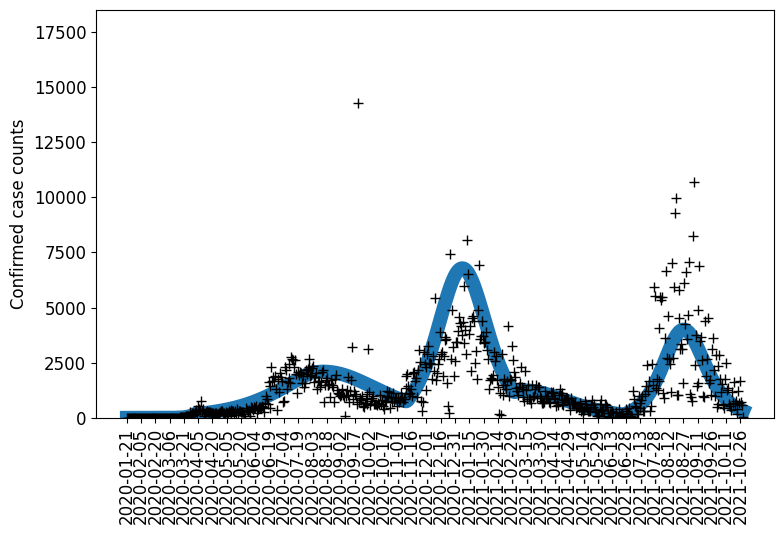

In [2]:
t0 = 13.3732945
t1 = 55.7370931
t2 = 115.090238
t3 = 95.9039057
l0 = 4.75679833
l1 = 1.49802493
l2 = 1.66502025
p0 = 0.309328327
p1 = 0.354077585
p2 = 0.241813521
th0 = 413.037265
th1 = 105.659741
m0 = 1.20686492
m1 = 1.99786425
b = 0.294062862
fd = 0.339553268
r = 3.14196677

p2 = 0.1
m0 = 1.5
m1 = 2.4
# th1 = 115

x0 = array([t0,t1,t2,t3,l0,l1,l2,p0,p1,p2,th0,th1,m0,m1,b,fd,r])
result = minimize(penalty, x0, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 200}, bounds = parameterBounds)
result = minimize(penalty, result.x, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 200}, bounds = parameterBounds)
result = minimize(penalty, result.x, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 200}, bounds = parameterBounds)
result = minimize(penalty, result.x, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 200}, bounds = parameterBounds)
result = minimize(penalty, result.x, method='Nelder-Mead', options={'adaptive': True, 'disp': True, 'maxiter': 200}, bounds = parameterBounds)
x0 = array(result.x)
dateIndex = ['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30','2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30','2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28', '2021-02-29', '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16', '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18', '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15', '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12', '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16', '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20', '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24', '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15', '2021-10-16', '2021-10-17', '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-23', '2021-10-24', '2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31']
fig = plt.figure(figsize=(24,24))
fig.set_size_inches(8,5.5)
ax = plt.subplot(1,1,1)
ax.plot(tSpan,process(tSpanSimulation,x0), linewidth=10.0, zorder = 1)    
ax.scatter(tSpan, NYTNewCases, 50, marker='+', linewidth = 1.0, color = 'black', zorder = 2)
ax.set_xticks(range(0,648,15))
_ = ax.set_xticklabels(dateIndex[::15], rotation=90)
ax.set_ylim(0,18500)
ax.set_ylabel('Confirmed case counts')
fig.tight_layout()
plt.savefig('c3b-fit.pdf')

In [3]:
x0[7:10]

array([0.29785539, 0.3144661 , 0.11902715])

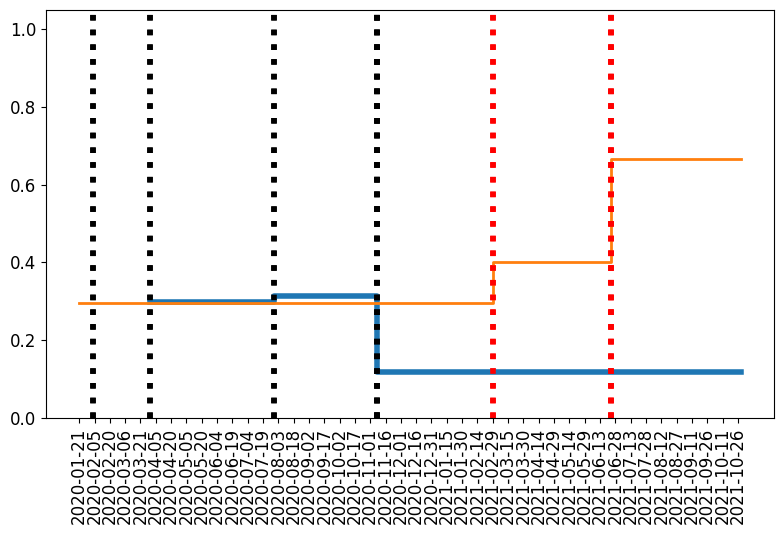

In [4]:
fig = plt.figure(figsize=(24,24))
fig.set_size_inches(8,5.5)
lw = 4
ax = plt.subplot(1,1,1)
bestFitPar = x0
sd_start_t = []
mut_takeoff_t = []
t = 0
mut_takeoff_t.append(t)
ylim = 1.05
for dt in bestFitPar[:nStages+1]:
    t += dt
    ax.axvline(t, 0,ylim, color='k', linestyle=':', linewidth=lw)   
    sd_start_t.append(t)
    sd_start_t.append(t)
sd_start_t_sub=sd_start_t[3:]
sd_start_t_sub.append(648)
ax.axvline(t, 0,ylim, color='k', linestyle=':', linewidth=lw)   
t = 0
for dt in bestFitPar[3*nStages+1:3*nStages+1+nMutations]:
    t += dt
    ax.axvline(t, 0,ylim, color='r', linestyle=':', linewidth=lw)    
    mut_takeoff_t.append(t)
    mut_takeoff_t.append(t)
mut_takeoff_t.append(648)    
fps=repeat(bestFitPar[7:10],2)
ax.plot(sd_start_t_sub,list(fps), linewidth=lw)   
betas=[]
betas.append(bestFitPar[14].tolist())
betas.append(bestFitPar[14].tolist())
alpha=(bestFitPar[12]*bestFitPar[14]).tolist()
delta=(bestFitPar[13]*bestFitPar[14]).tolist()
betas.append(alpha)
betas.append(alpha)
betas.append(delta)
betas.append(delta)
ax.plot(mut_takeoff_t,betas, linewidth=2)   
t = 0
for dt in bestFitPar[:nStages+1]:
    t += dt
    ax.axvline(t, 0,ylim, color='k', linestyle=':', linewidth=lw)   

ax.axvline(t, 0,ylim, color='k', linestyle=':', linewidth=lw)   
t = 0
for dt in bestFitPar[3*nStages+1:3*nStages+1+nMutations]:
    t += dt
    ax.axvline(t, 0,ylim, color='r', linestyle=':', linewidth=lw)   
ax.axvline(t, 0,ylim, color='r', linestyle=':', linewidth=lw)   
dateIndex = ['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30','2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30','2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28', '2021-02-29', '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16', '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18', '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15', '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12', '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16', '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20', '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24', '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15', '2021-10-16', '2021-10-17', '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-23', '2021-10-24', '2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31']
ax.set_xticks(range(0,648,15))
_ = ax.set_xticklabels(dateIndex[::15], rotation=90)
ax.set_ylim(0,ylim)
fig.tight_layout()
plt.savefig('c3b-feasibility.pdf')

In [5]:
x0

array([1.37362658e+01, 5.55855311e+01, 1.21709393e+02, 1.00774834e+02,
       5.18482149e+00, 1.56433887e+00, 1.72347732e+00, 2.97855392e-01,
       3.14466097e-01, 1.19027146e-01, 4.05185354e+02, 1.15646197e+02,
       1.36060392e+00, 2.26594027e+00, 2.94287404e-01, 3.56904085e-01,
       2.75927898e+00])